In [1]:
# Question 1
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

df = pd.read_csv("cereal.csv")

The datasource is a kaggle dataset covering the nutrition facts of 80 brands of cereal. It keeps track of: 
    Name: Name of cereal
    mfr: Manufacturer of cereal
        A = American Home Food Products;
        G = General Mills
        K = Kelloggs
        N = Nabisco
        P = Post
        Q = Quaker Oats
        R = Ralston Purina 
    type:
        cold
        hot 
    calories: calories per serving
    protein: grams of protein
    fat: grams of fat
    sodium: milligrams of sodium
    fiber: grams of dietary fiber
    carbo: grams of complex carbohydrates
    sugars: grams of sugars
    potass: milligrams of potassium
    vitamins: vitamins and minerals - 0, 25, or 100, indicating the typical percentage of FDA recommended
    shelf: display shelf (1, 2, or 3, counting from the floor)
    weight: weight in ounces of one serving
    cups: number of cups in one serving
    rating: a rating of the cereals (Possibly from Consumer Reports?)

The link to the dataset: https://www.kaggle.com/datasets/crawford/80-cereals

The main inquiry question is to predict which cereals are most popular by analyzing the ratings and other nutritional attributes, such as sugar, fat, etc.

Link to github repository: https://github.com/Mughki/DataAnalytics

In [2]:
# Question 2
# Drop any unwanted features if necessary
df.drop('mfr', axis=1, inplace=True)
df.drop('type', axis=1, inplace=True)
df.drop('shelf', axis=1, inplace=True)
df.drop('weight', axis=1, inplace=True)
df.drop('cups', axis=1, inplace=True)

# Check if there are any missing values and address them
df = df.loc[df['rating'] != 0]
df = df.dropna()
print(df.isnull().sum())
print()

# Check if any duplicates and address them
print(df.dtypes)
print()

# For categorical variables, check if there are any inconsistent inputs and address them
print(df['name'].tail(5))
print()

name        0
calories    0
protein     0
fat         0
sodium      0
fiber       0
carbo       0
sugars      0
potass      0
vitamins    0
rating      0
dtype: int64

name         object
calories      int64
protein       int64
fat           int64
sodium        int64
fiber       float64
carbo       float64
sugars        int64
potass        int64
vitamins      int64
rating      float64
dtype: object

72                Triples
73                   Trix
74             Wheat Chex
75               Wheaties
76    Wheaties Honey Gold
Name: name, dtype: object



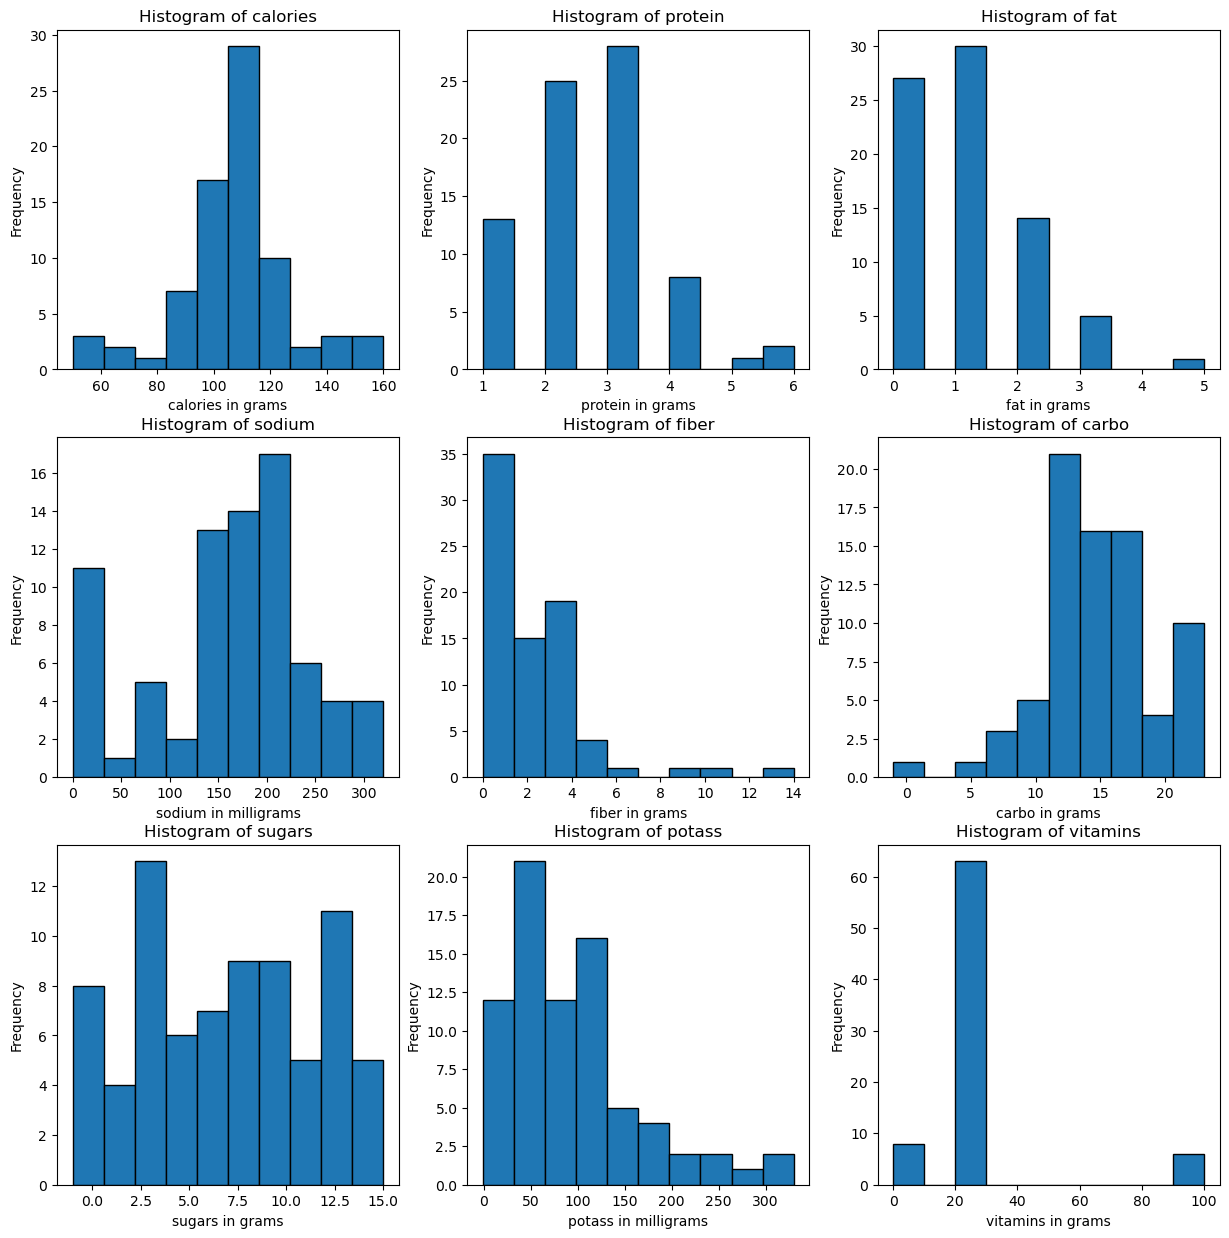

In [3]:
# Question 2
# For numeric variables, check any outliers and remove them or replace them with a certain value
numericVariables = ['calories', 'protein', 'fat', 'sodium', 'fiber', 'carbo', 'sugars', 'potass', 'vitamins']

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, variable in enumerate(numericVariables):
    row, col = i // 3, i % 3
    
    if variable == 'sodium':
        axes[row, col].hist(df[variable], edgecolor='black')
        axes[row, col].set_title('Histogram of sodium')
        axes[row, col].set_xlabel(f'{variable} in milligrams')
    elif variable == 'potass':
        axes[row, col].hist(df[variable], edgecolor='black')
        axes[row, col].set_title('Histogram of potass')
        axes[row, col].set_xlabel(f'{variable} in milligrams')
    else:
        axes[row, col].hist(df[variable], edgecolor='black')
        axes[row, col].set_title(f'Histogram of {variable}')
        axes[row, col].set_xlabel(f'{variable} in grams')
        
    axes[row, col].set_ylabel('Frequency')

plt.show()

In [4]:
# Question 3
from sklearn.feature_selection import SelectKBest, f_regression, f_classif

df = df.replace(-1, 0)

# Perform f_regression test for feature selection
x = df[['calories', 'protein', 'fat', 'sodium', 'fiber', 'carbo', 'sugars', 'potass', 'vitamins']]
y = df['rating']

fs = SelectKBest(score_func=f_regression, k='all')
bestFeatures = fs.fit(x, y)
np.set_printoptions(suppress = True)

print("F-Scores:", bestFeatures.scores_)
print("P-Values:", bestFeatures.pvalues_)
print()

# Dropping variables with P-values over 0.05
df.drop('carbo', axis=1, inplace=True)

F-Scores: [ 67.92229156  21.33685396  15.09150931  14.3961655   38.85085109
   0.22290323 103.67194113  12.69943447   4.60610717]
P-Values: [0.         0.00001566 0.00021903 0.00029799 0.00000002 0.63820747
 0.         0.00064026 0.0350929 ]



In [5]:
# Question 4
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, ConfusionMatrixDisplay

x = df[['calories', 'protein', 'fat', 'sodium', 'fiber', 'sugars', 'potass', 'vitamins']]
y = df['rating'] 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

r2 = r2_score(y_test, y_pred)

print(f"R^2: {r2:.4f}")

R^2: 0.9854
